### Monte Carlo Simulation in Option Pricing

Seho Jeong, Sogang University

References
- Lewinson, Eryk. 2022. "Python for Finance Cookbook." Packt Publishing.

In [1]:
# Import the libraries.

import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

In [2]:
cm = ['#116FA1', '#2DC0D2', '#E0B266', '#00979F', '#70CAC6', '#005A7D']
bg = '#F9F9F9'

In [3]:
# Define the sample period.
START_DATE = '2019-01-01'
END_DATE = '2019-07-31'

#### Simulation of Stock Price Dynamics via Geometric Brownian Motion

In [4]:
# Download data from Yahoo Finance.
ticker = 'MSFT'
df = yf.download(ticker, start=START_DATE, end=END_DATE, auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


Sample average of returns: 0.242%


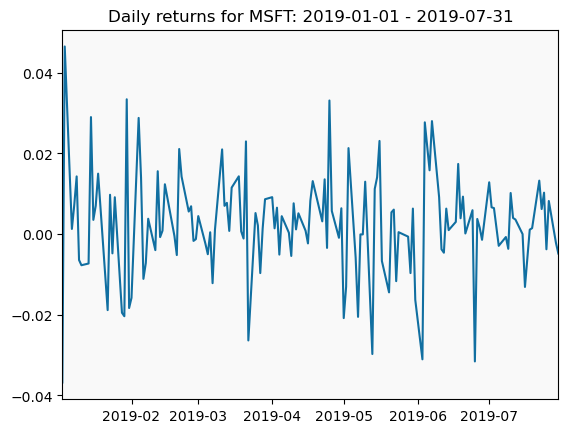

In [5]:
# Calculate daily returns.

adj_close = df.Close.MSFT
returns = adj_close.pct_change().dropna()

print(f'Sample average of returns: {100 * returns.mean():.3f}%')

# Plot the time series of returns.
fig, ax = plt.subplots()

ax.plot(returns, color=cm[0])

ax.set_title(f'Daily returns for {ticker}: {START_DATE} - {END_DATE}')
ax.set_facecolor(bg)
ax.set_xmargin(0.)

plt.show()

In [6]:
# Split data into the training and test sets.

train = returns[:'2019-06-30']
test = returns['2019-07-01':]

# Specify the parameters for the simulation.
T = len(test)                    # length of the forecast horizon
N = len(test)                    # number of time increments in the forecast horizon
S_0 = adj_close[train.index[-1]] # initial stock price
n_sims = 100                     # number of simulation paths
μ = train.mean()                 # drift coefficient
σ = train.std()                  # diffusion coefficient

In [11]:
# Define the function used for simulations.
def simulate_gbm(s_0, μ, σ, n_sims, T, N, random_seed=42, antithetic_var=False):
    """ 
    Function used for simulating stock returns using Geometric Brownian Motion.
    """

    # Set random seed for replications.
    np.random.seed(random_seed)

    dt = T / N # time increment
    
    if antithetic_var:
        dW_ant = np.random.normal(scale=np.sqrt(dt), size=(int(n_sims / 2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else:
        dW = np.random.normal(scale=np.sqrt(dt), size=(n_sims, N + 1))

    # Simulate the evolution of the process.
    S_t = s_0 * np.exp(np.cumsum((μ - 0.5 * σ ** 2) * dt + σ * dW, axis=1))
    S_t[:, 0] = s_0

    return S_t

In [12]:
# Run simulations and store the result in a DataFrame.
gbm_simulations = simulate_gbm(S_0, μ, σ, n_sims, T, N)
sim_df = pd.DataFrame(gbm_simulations.T, index=train.index[-1:].union(test.index))

sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-28,127.017807,127.017807,127.017807,127.017807,127.017807,127.017807,127.017807,127.017807,127.017807,127.017807,...,127.017807,127.017807,127.017807,127.017807,127.017807,127.017807,127.017807,127.017807,127.017807,127.017807
2019-07-01,128.251038,125.244361,123.796124,129.271333,127.587855,124.230094,126.582342,126.875734,130.231192,125.717088,...,123.534659,125.689939,122.710024,127.600909,131.829939,128.728547,125.931941,125.990507,126.400094,131.250538
2019-07-02,129.709619,124.597983,123.299911,130.225418,128.060200,124.626495,125.277710,130.498207,130.061159,126.638201,...,122.757271,122.730109,126.099716,127.322930,133.916228,130.146694,127.528273,126.465294,128.963150,131.214485
2019-07-03,132.782230,125.083202,125.410163,129.373002,130.092671,129.248107,128.293054,131.665449,135.364346,127.924627,...,124.522501,123.382579,128.580746,127.897023,136.545733,128.415149,126.924798,129.507585,130.267622,130.875146
2019-07-05,132.664808,123.398274,126.304279,130.327403,129.139423,129.208455,127.210085,129.819477,136.862146,130.160688,...,126.471682,123.675298,129.257824,129.669276,137.035286,130.580424,126.822294,127.607492,128.583130,130.856650


In [13]:
# Create a DataFrame with the average value for each time step and the corresponding actual stock price.
res_df = sim_df.mean(axis=1).to_frame()
res_df = res_df.join(df.Close.MSFT)
res_df.columns = ['simulation_average', 'adj_close_price']

res_df.head()

,simulation_average,adj_close_price
Date,,
2019-06-28,127.017807,127.017807
2019-07-01,127.832520,128.648621
2019-07-02,128.450680,129.502045
2019-07-03,128.767632,130.336395
2019-07-05,129.075159,129.957108


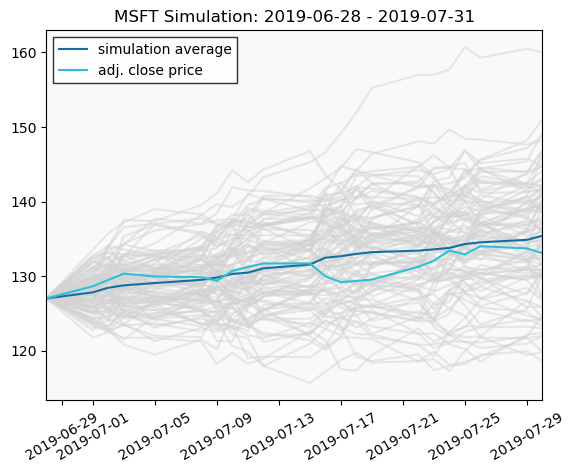

In [14]:
# Plot the results of the simulation.
fig, ax = plt.subplots()

ax.plot(sim_df, alpha=0.5, color='lightgray')
ax.plot(res_df.simulation_average, color=cm[0], label='simulation average')
ax.plot(res_df.adj_close_price, color=cm[1], label='adj. close price')

ax.legend(fancybox=False, edgecolor='k')
ax.set_title(f'{ticker} Simulation: {train.index[-1].date()} - {END_DATE}')
ax.set_facecolor(bg)
ax.set_xmargin(0)
plt.xticks(rotation=30)

plt.show()

In [15]:
# Compare the execution time.
%timeit gbm_simulations = simulate_gbm(S_0, μ, σ, n_sims, T, N)
%timeit gbm_simulations = simulate_gbm(S_0, μ, σ, n_sims, T, N, antithetic_var=True)

27.6 μs ± 381 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
21 μs ± 206 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Pricing European Option using Simulations

In [ ]:
# Define the parameters for the valuation.
S_0 = 100
K = 100
r = 0.05